# Predicting a Production Line Performance and Availability

## A case study with real production data

The context is that of manufacturing production lines.

Production lines can be thought of as sequences of industrial machines. We refer to the last machine in the sequence as the bottleneck machine.


The performance of the machines is usually mesured via KPIs (Key Performance Indicators).

The aim of this test is to predict two of such KPIs given two complementary datasets.

**Specifically the goals for this notebook are**:
- Provide an Exploratory Data Analysis (EDA) on the two provided datasets
- Pre-process a dataset which will be used for training-test purposes   
- Train and evaluate models for predicting two KPIs  


<hr>

## KPIs: Domain Knowledge
To be more specific, the KPIs to be predicted are the **availability** and the **performance**. 
The two KPIs are defined as follows. The datasets already contain the computed KPIs.  

### Availability (Disponibilità)
Given the following: 
- *ActiveTime*: time when the machine is producing units (seconds)
- *DownTime*: time when the machine is not producing but was scheduled to do it (seconds)

The sum of $Active Time + Down Time$ gives the *planned production time*

This Key Performance Indicator is defined as follows: 

$$ Availability = \dfrac{ActiveTime}{ActiveTime + DownTime}$$

### Performance (Efficienza)
- *ActiveTime*: time when the machine is producing units (seconds)
- *ProducedUnits*: produced units in the time interval (units)
- *NominalVelocity*: the set nominal velocity (units/seconds)for the machine

This Key Performance Indicator is defined as follows: 

$$ Performance = \dfrac{ProducedUnits \div ActiveTime}{NominalVelocity} $$

<hr>

## Alarms and Telemetry Datasets
For this case study, real world data are used. Data is available only for the *bottleneck* machine of a production line. The datasets have been already processed in order to make the time discrete (slotted) into hours and remove some sensitive information.

Two datasets are provided, one for the alarms and one for the telemetry data of the *bottleneck* machine. 

### Alarms Dataset
The `dataset_allarmi.csv.zip` dataset contains information on alarm events which has been aggregated hourly. 

The following attributes are available: 
- `timestamp`: timestamp value for the record; 
- `allarme_id`: type of the alarm which uniquely identifies it; it can be repeated at different timestamps if the alarm occurred multiple times;
- `allarme_bloccante`: if true, specifies that the occurence of the alarm of type `allarme_id` causes the machine to stop;   
- `allarme_durata_media`: mean duration of the alarm;
- `allarme_tf_medio`: mean machine stopping time caused by the alarm; 
- `allarme_numero`: the number of times the alarm of type`allarme_id` occurred during the hour; 

Only years, months, days and hours are specified for the *timestamp* column. A record with timestamp `2020-02-03 15:00:00` refers to an alarm type occurred once or multiple times from the `15:00` and the `15:59` of that day;

### Telemetry Dataset
The `dataset_telemetria.csv.zip` dataset contains the telemetry (production, timings, etc...) data which has been aggregated hourly.

The following attributes are available: 
- `timestamp`: timestamp value for the record;
- `tel_pezzi_prodotti`: aggregated produced units;
- `tel_tempo_attivo`: aggregated active time;
- `tel_tempo_fermo`: aggregated down time;
- `tel_velocità_nominale`: nominal velocity of the machine;
- `disponibilità`: hourly computed KPI;
- `efficienza`: hourly computed KPI; 

Only years, months, days and hours are specified for the *timestamp* column. A record with timestamp `2020-02-03 15:00:00` refers to telemetry data acquired from the `15:00` and the `15:59` of that day and aggregated for discretization purposes;

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

def plot_bar_plot(data,size=(20,10),title=None,x=None,y=None):
    plt.figure(figsize=size)
    sns.set(style="darkgrid")
    g=sns.barplot(data=data,x=x,y=y)
    
    for p in g.patches:
      g.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')
    if title:
      g.set_title(title)

    g.grid(True)

sns.set(rc={'figure.figsize':(15,10)})
telemetry_df=pd.read_csv('/data/telemetry.csv')
alarms_df=pd.read_csv('/data/alarms.csv')

# Exploaratory Data Analysis
Provide an anlaysis of the two provided datasets (by means of example: correlations, missing values, outliers, etc... ). You may include charts and markdown cells with comments for interesting outcomes.

# Telemetry DF

In [172]:
telemetry_df.head()

,timestamp,tel_pezzi_prodotti,tel_tempo_attivo,tel_tempo_fermo,tel_velocità_nominale,disponibilità,efficienza
0,2020-04-09 04:00:00,703.693957,1618,1980,0.46462,0.4497,0.9361
1,2020-04-09 05:00:00,1320.959660,2975,630,0.46462,0.8252,0.9557
2,2020-04-09 06:00:00,886.029560,2031,1569,0.46462,0.5642,0.9389
3,2020-04-09 07:00:00,542.546569,1263,2337,0.46462,0.3508,0.9246
4,2020-04-09 08:00:00,948.481177,2154,1446,0.46462,0.5983,0.9477


In [173]:


telemetry_df.info()
telemetry_df.describe().T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              736 non-null    object 
 1   tel_pezzi_prodotti     736 non-null    float64
 2   tel_tempo_attivo       736 non-null    int64  
 3   tel_tempo_fermo        736 non-null    int64  
 4   tel_velocità_nominale  736 non-null    float64
 5   disponibilità          736 non-null    float64
 6   efficienza             682 non-null    float64
dtypes: float64(4), int64(2), object(1)
memory usage: 40.4+ KB


,count,mean,std,min,25%,50%,75%,max
tel_pezzi_prodotti,736.0,805.009467,5.624146e+02,0.00000,437.717369,850.900061,1168.733981,7178.516732
tel_tempo_attivo,736.0,1837.868207,1.253954e+03,0.00000,1022.250000,1984.000000,2647.000000,15895.000000
tel_tempo_fermo,736.0,1859.578804,1.375549e+03,35.00000,953.750000,1622.500000,2553.250000,17972.000000
tel_velocità_nominale,736.0,0.464620,1.113238e-15,0.46462,0.464620,0.464620,0.464620,0.464620
disponibilità,736.0,0.499464,2.834506e-01,0.00000,0.286775,0.549300,0.735075,0.990300
efficienza,682.0,0.910377,1.398406e-01,0.00000,0.897075,0.942150,0.966050,1.021000


## Alarms dataset

In [174]:
alarms_df.head()

,timestamp,allarme_id,allarme_bloccante,allarme_durata_media,allarme_tf_medio,allarme_numero
0,2020-04-09 04:00:00,0,NaN,93.875,-1.0,16
1,2020-04-09 04:00:00,4,NaN,22.000,-1.0,2
2,2020-04-09 04:00:00,11,NaN,916.000,-1.0,1
3,2020-04-09 04:00:00,12,NaN,916.000,-1.0,1
4,2020-04-09 04:00:00,13,NaN,916.000,-1.0,1


In [175]:
alarms_df.info()
alarms_df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8875 entries, 0 to 8874
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   timestamp             8875 non-null   object 
 1   allarme_id            8875 non-null   int64  
 2   allarme_bloccante     3811 non-null   object 
 3   allarme_durata_media  8875 non-null   float64
 4   allarme_tf_medio      8875 non-null   float64
 5   allarme_numero        8875 non-null   int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 416.1+ KB


,count,mean,std,min,25%,50%,75%,max
allarme_id,8875.0,65.608225,51.517089,0.0,4.0,67.0,107.0,157.0
allarme_durata_media,8875.0,304.626471,2113.198583,1.0,12.0,40.5,136.0,120500.0
allarme_tf_medio,8875.0,118.976054,796.754366,-1.0,-1.0,-1.0,24.5,30029.0
allarme_numero,8875.0,3.434592,5.682958,1.0,1.0,1.0,3.0,88.0


The first thing we notice is that there are missing or null elements, 'efficienza' for telemetry dataset and 'allarme_bloccante' for alarms dataset.

In [176]:
print("=======TELEMETRY DF null values =======")
telemetry_df.isnull().sum()

=======TELEMETRY DF null values =======


timestamp                 0
tel_pezzi_prodotti        0
tel_tempo_attivo          0
tel_tempo_fermo           0
tel_velocità_nominale     0
disponibilità             0
efficienza               54
dtype: int64

In [177]:
print("=======ALARMS DF null values =======")
alarms_df.isnull().sum()

=======ALARMS DF null values =======


timestamp                  0
allarme_id                 0
allarme_bloccante       5064
allarme_durata_media       0
allarme_tf_medio           0
allarme_numero             0
dtype: int64

### Dataset manipulation

### deal with null values-> replace missing with false in alarm dataset, recalculate data on telemetry dataset

Pero' notiamo che i valori nulli della telemetria per l'efficienza sono negli slot orari in cui non c'e' stata produzione, quindi possiamo assumere efficienza=0 in quei slot

In [178]:
telemetry_df['efficienza'].fillna(0,inplace=True)
telemetry_df.isnull().sum()



timestamp                0
tel_pezzi_prodotti       0
tel_tempo_attivo         0
tel_tempo_fermo          0
tel_velocità_nominale    0
disponibilità            0
efficienza               0
dtype: int64

In [179]:
alarms_df['allarme_bloccante'].fillna(False,inplace=True)
alarms_df.isnull().sum()


timestamp               0
allarme_id              0
allarme_bloccante       0
allarme_durata_media    0
allarme_tf_medio        0
allarme_numero          0
dtype: int64

In [180]:
alarms_df.head()

,timestamp,allarme_id,allarme_bloccante,allarme_durata_media,allarme_tf_medio,allarme_numero
0,2020-04-09 04:00:00,0,False,93.875,-1.0,16
1,2020-04-09 04:00:00,4,False,22.000,-1.0,2
2,2020-04-09 04:00:00,11,False,916.000,-1.0,1
3,2020-04-09 04:00:00,12,False,916.000,-1.0,1
4,2020-04-09 04:00:00,13,False,916.000,-1.0,1


Una cosa comoda per gli esperimenti successivi e' sostituire il -1 nel tempo fermo medio a zero.

In [181]:
alarms_df.loc[(alarms_df['allarme_tf_medio'] == -1)] = 0
alarms_df.head()

,timestamp,allarme_id,allarme_bloccante,allarme_durata_media,allarme_tf_medio,allarme_numero
0,0,0,0,0.0,0.0,0
1,0,0,0,0.0,0.0,0
2,0,0,0,0.0,0.0,0
3,0,0,0,0.0,0.0,0
4,0,0,0,0.0,0.0,0


##  Values Distribution

### Telemetry

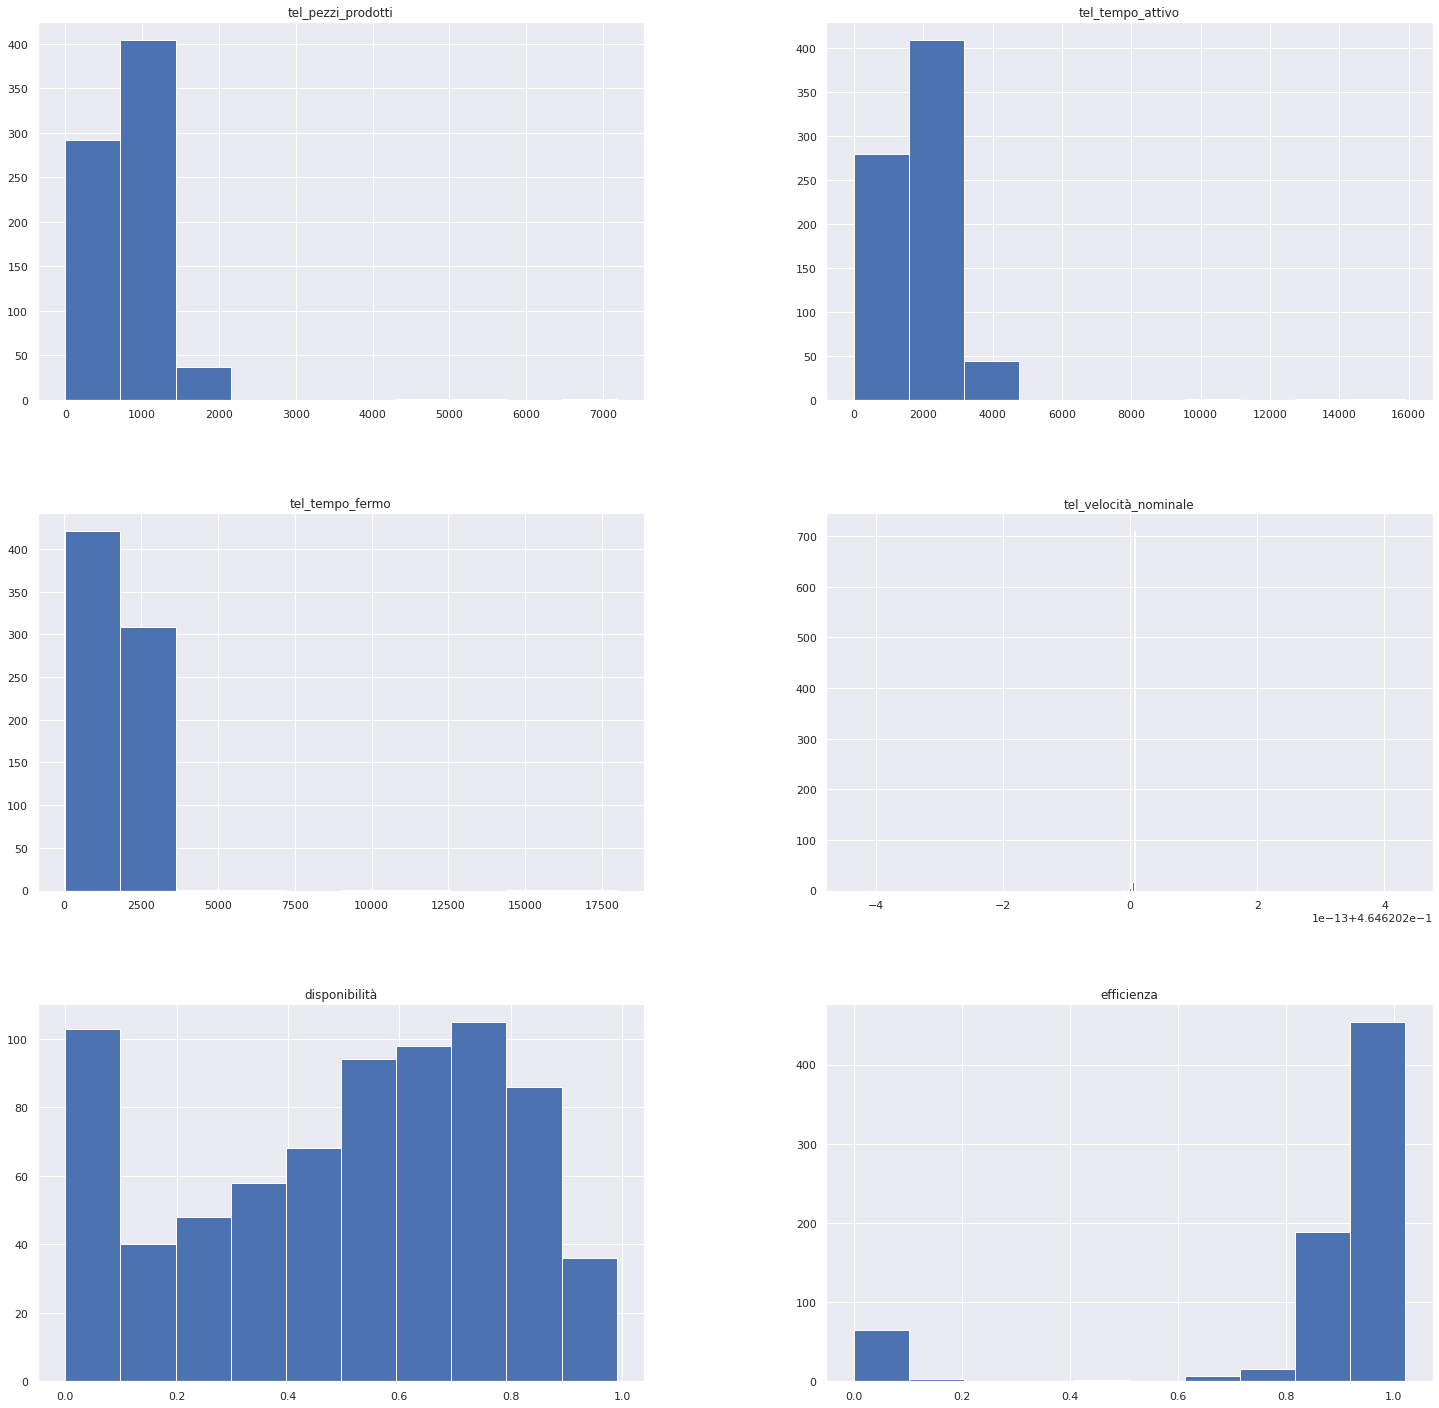

In [182]:
telemetry_df.hist(figsize=(25,25))
plt.show()

### Alarms

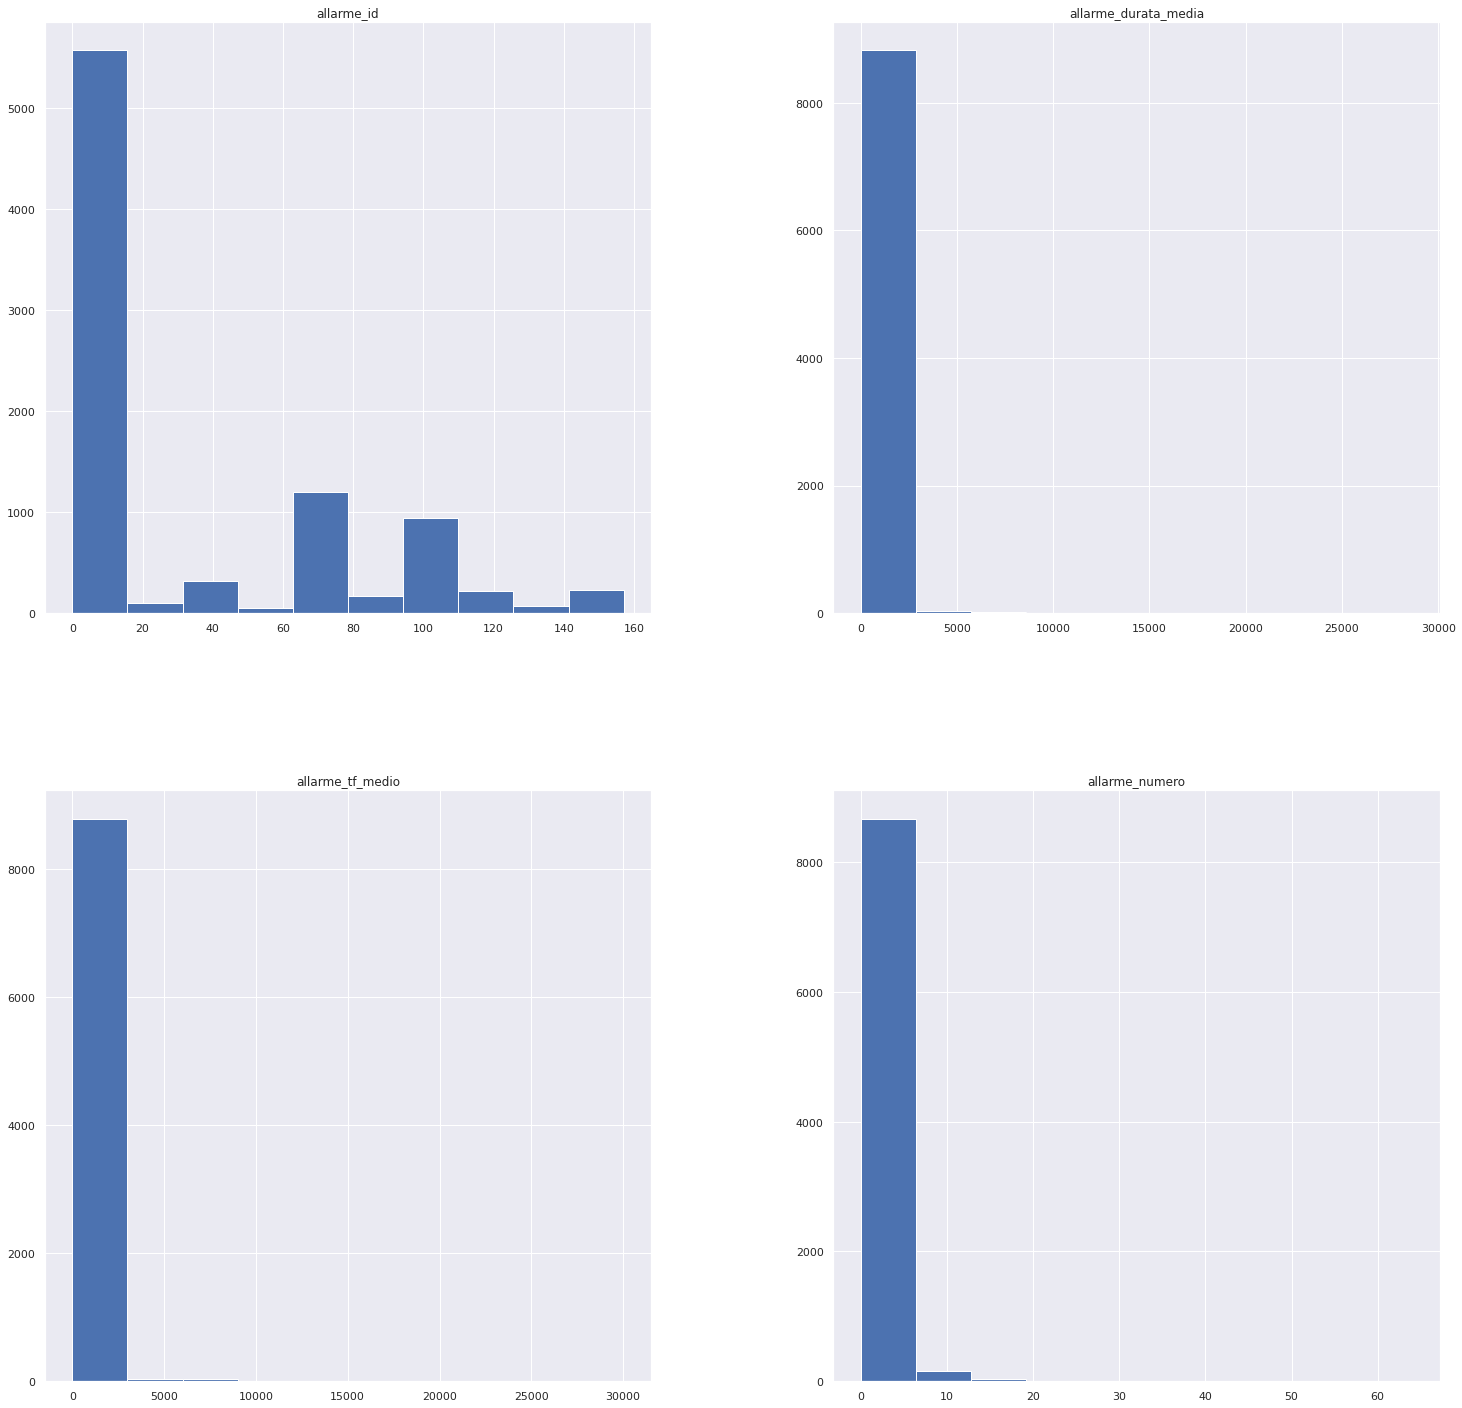

In [183]:
alarms_df.hist(figsize=(25,25))
plt.show()

todo commento

## Correlation matrix

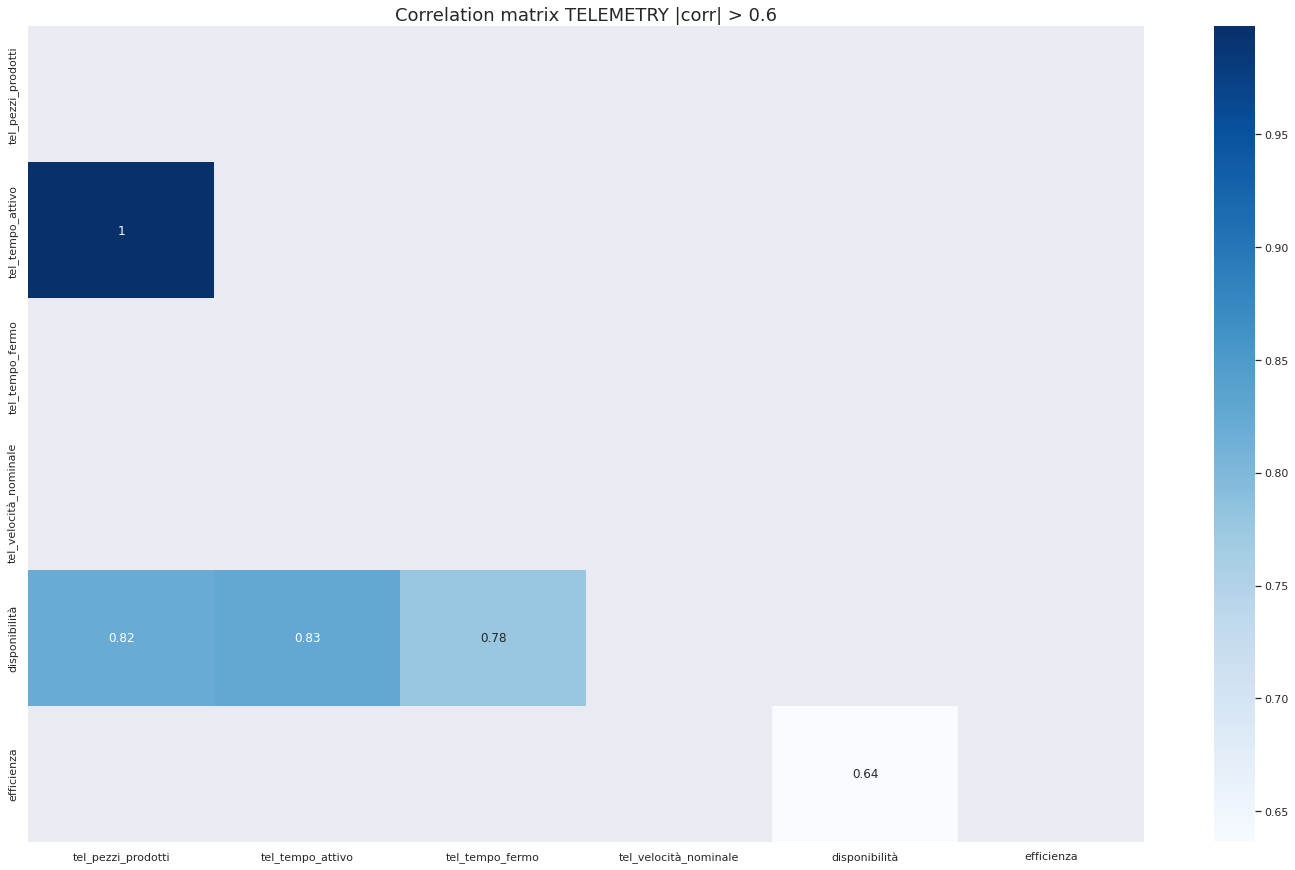

In [184]:
plt.figure(figsize = (25,15))
corr=abs(telemetry_df.corr())
lower_triangle  = np.tril(corr, k = -1)
mask = lower_triangle < abs(0.6) #Mask the correlation less than 0.6
sns.heatmap(lower_triangle,xticklabels = corr.index, yticklabels = corr.columns, annot = True,cmap= 'Blues', mask = mask)
plt.title('Correlation matrix TELEMETRY |corr| > 0.6',fontsize=18)
plt.show()

alcuni valori altamente correlati (corr > |0.6|), cio' significa che due (o piu') features trasportano lo stesso quantitativo di informazione, ora (dipendentemente dall'algoritmo che si vuole utilizzare) e' consigliabile o eliminarle manualmente, o applicare una PCA, tuttavia essendo il numero di attributi limitato la PCA in questo contesto e' un overkill.

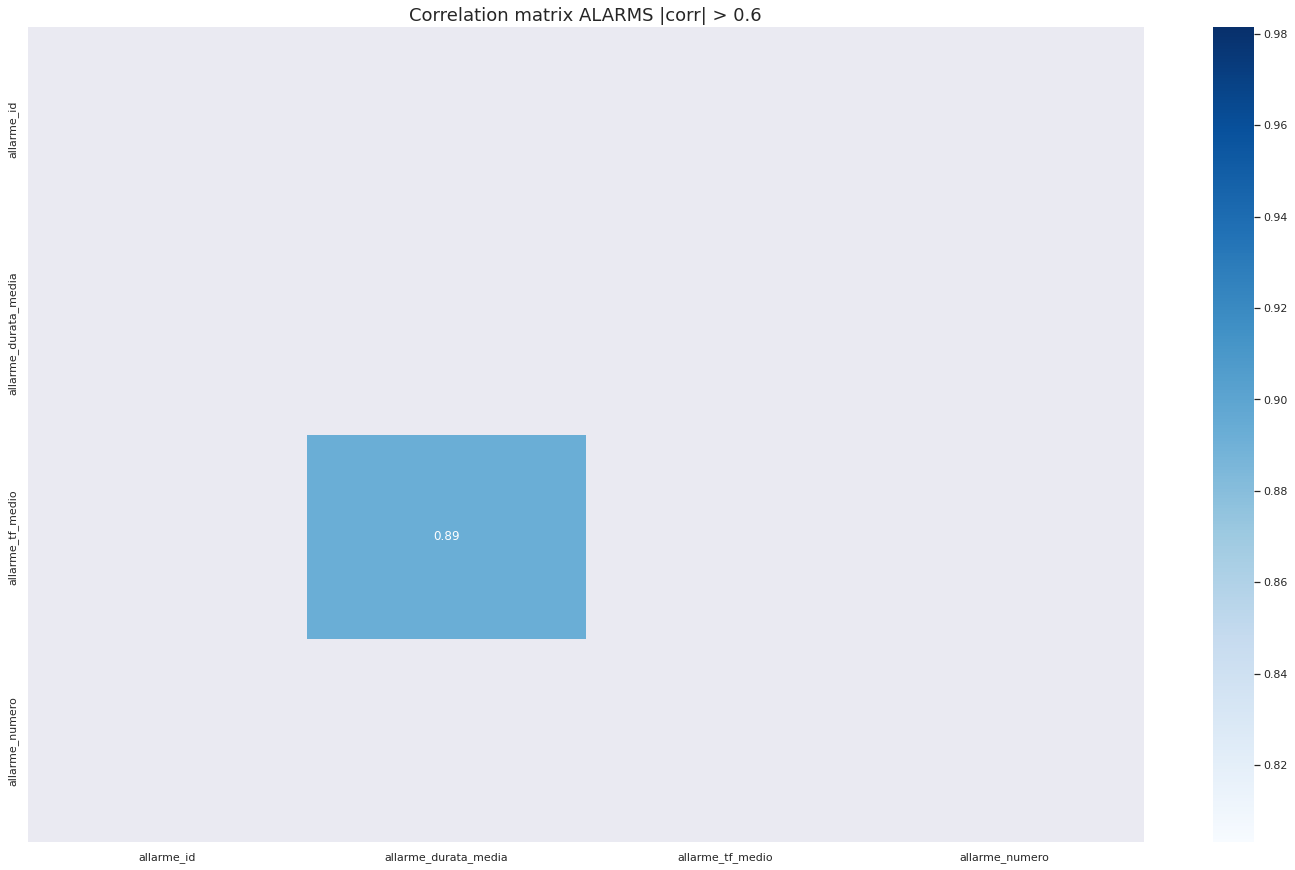

In [186]:
plt.figure(figsize = (25,15))
corr=abs(alarms_df.corr())
lower_triangle  = np.tril(corr, k = -1)
mask = lower_triangle < abs(0.6) #Mask the correlation less than 0.6
sns.heatmap(lower_triangle,xticklabels = corr.index, yticklabels = corr.columns, annot = True,cmap= 'Blues', mask = mask)
plt.title('Correlation matrix ALARMS |corr| > 0.6',fontsize=18)
plt.show()

Nessun attributo altamente correlato, nessuna modifica necessaria sugli attributi del dataset alarms

### KPI over time

<AxesSubplot:xlabel='timestamp', ylabel='efficienza'>

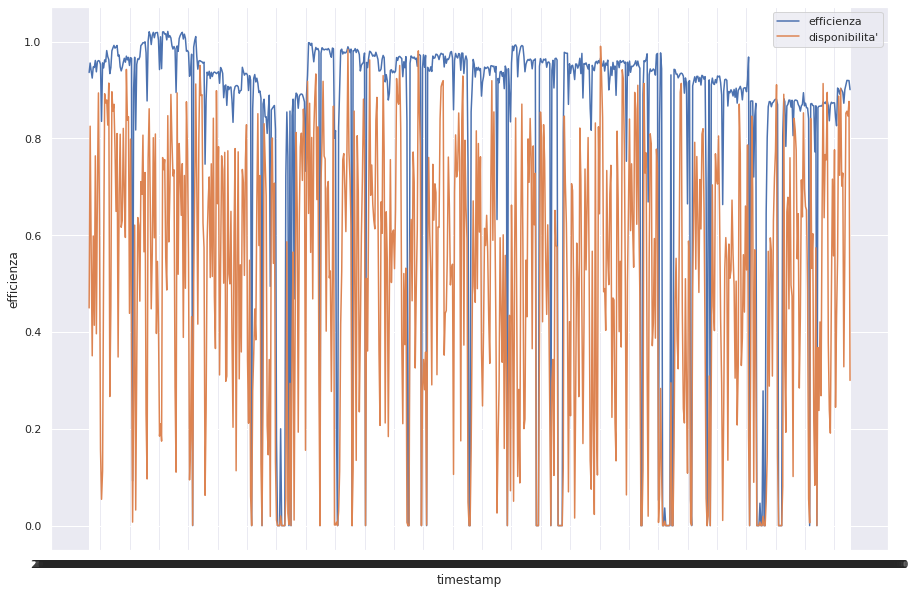

In [187]:
# Plot the responses for different events and regions
sns.lineplot(x="timestamp", y="efficienza", label="efficienza",data=telemetry_df)
sns.lineplot(x="timestamp", y="disponibilità",label="disponibilita'",data=telemetry_df)

I KPI sembrano non essere dipendenti dal tempo.

### TOP ALARMS ANALYSIS

In [190]:
top_alarms_gorouped=alarms_df.groupby('allarme_id', as_index=False).agg({'allarme_tf_medio':'sum','allarme_numero':'sum'})
top_alarms_gorouped.rename(columns = {'allarme_tf_medio':'tot_tf_medio', 'allarme_numero':'tot_alarms'}, inplace = True)

top_alarms_gorouped=top_alarms_gorouped.sort_values(by='tot_tf_medio',ascending=False)
display(top_alarms_gorouped)

,allarme_id,tot_tf_medio,tot_alarms
63,102,289856.833333,202
1,4,132029.618254,607
21,38,124461.500000,24
68,107,69106.303762,2101
26,43,24087.637704,305
...,...,...,...
52,81,7.000000,1
50,77,7.000000,1
62,98,4.111111,9
58,94,4.000000,1


<AxesSubplot:xlabel='tot_tf_medio', ylabel='allarme_id'>

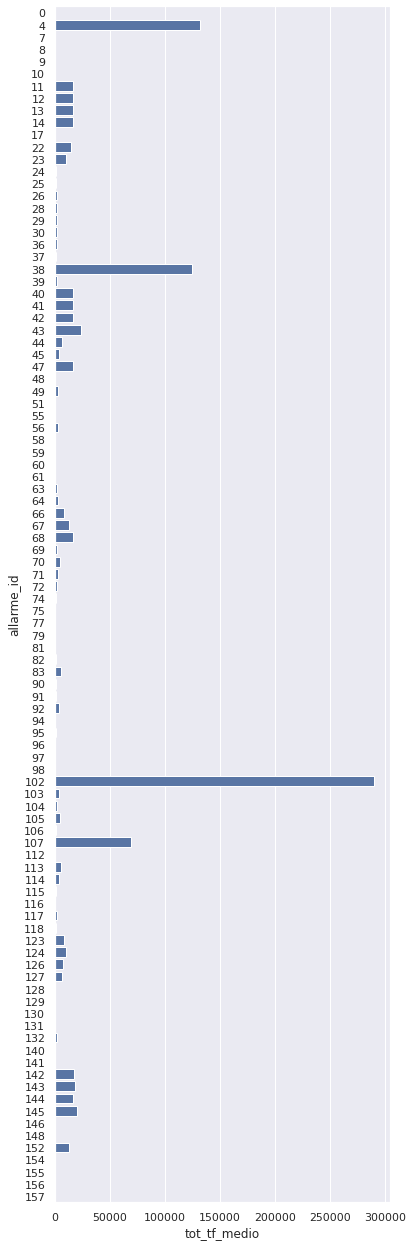

In [191]:
f, ax = plt.subplots(figsize=(6, 22))
sns.barplot(x="tot_tf_medio", y="allarme_id", data=top_alarms_gorouped,color="b",orient = 'h')


Iniziamo a notare che l'errore 102 e' quello piu' impattante in tempo di macchinario fermo.

### JOIN DATASETS

Due vie, completamente dipendenti dal tipo di informazione che si vuole estrarre nei passi successivi (e soprattutto da quale deve essere l'X per cui predirre i KPI Y e Z?); poiche' i due dataset hanno granularita' differenti, possiamo inserire per ogni riga del dataset alarms gli attributi relativi alla stessa ora del dataset della telemetria, o aggregare i dati per gli allarmi all'ora, per avere la stessa granularita' della telemetria; ad esempio tot_allarmi_per_ora,tot_tf_per_ora, tot_allarmi_bloccanti_per_ora etc etc.

Entrambi gli approcci hanno dei pro e dei contro;
nel secondo caso (aggregando i dati allarmistici) essendo i KPI sono calcolati all'ora, e' quindi lo slot orario la quantita' minima di interesse, e tutto quello che e' successo in quell'ora (tutti gli allarmi, i tempi morti etc etc) ci permette di avere una consistenza in fase di predizione, tuttavia aggregando i dati allarmistici andremmo a perdere il dettaglio sull'id dell'allarme,che abbiamo capito essere molto importante per questa analisi. 

Nel primo caso invece, rischiamo di 'confondere' gli eventuali algoritmi di regression, poiche' se aggiungiamo i KPI (e il resto deglle features di interesse) per ogni riga del dataset alarms, questa informazione si riferisce comunque a tutto quello che e' successo in quell'ora, e non e' direttamente conseguenza di quella riga di allarme, pero' questo ci consente dimantenere l'informazione puntuale sull'id dell allarme, che ritengo essere fondamentale in fase di prediction, quindi provo a seguire questa strada.

In [197]:
print(alarms_df.shape)
print(telemetry_df.shape)
merged_df=pd.merge(alarms_df,telemetry_df,on=["timestamp"],how="inner")
merged_df.info()
print(merged_df.shape)

merged_df.to_csv('/data/merged.csv',index=False)

(8875, 6)
(736, 7)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3747 entries, 0 to 3746
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              3747 non-null   object 
 1   allarme_id             3747 non-null   int64  
 2   allarme_bloccante      3747 non-null   object 
 3   allarme_durata_media   3747 non-null   float64
 4   allarme_tf_medio       3747 non-null   float64
 5   allarme_numero         3747 non-null   int64  
 6   tel_pezzi_prodotti     3747 non-null   float64
 7   tel_tempo_attivo       3747 non-null   int64  
 8   tel_tempo_fermo        3747 non-null   int64  
 9   tel_velocità_nominale  3747 non-null   float64
 10  disponibilità          3747 non-null   float64
 11  efficienza             3747 non-null   float64
dtypes: float64(6), int64(4), object(2)
memory usage: 380.6+ KB
(3747, 12)


In [195]:
merged_df.head()

,timestamp,allarme_id,allarme_bloccante,allarme_durata_media,allarme_tf_medio,allarme_numero,tel_pezzi_prodotti,tel_tempo_attivo,tel_tempo_fermo,tel_velocità_nominale,disponibilità,efficienza
0,2020-04-09 04:00:00,70,True,1.5,2.0,2,703.693957,1618,1980,0.46462,0.4497,0.9361
1,2020-04-09 04:00:00,71,True,1.0,2.0,1,703.693957,1618,1980,0.46462,0.4497,0.9361
2,2020-04-09 04:00:00,72,True,1.0,2.0,1,703.693957,1618,1980,0.46462,0.4497,0.9361
3,2020-04-09 04:00:00,92,True,11.5,12.0,4,703.693957,1618,1980,0.46462,0.4497,0.9361
4,2020-04-09 04:00:00,102,True,2880.0,2907.0,1,703.693957,1618,1980,0.46462,0.4497,0.9361


In [196]:
merged_df.isnull().sum()

timestamp                0
allarme_id               0
allarme_bloccante        0
allarme_durata_media     0
allarme_tf_medio         0
allarme_numero           0
tel_pezzi_prodotti       0
tel_tempo_attivo         0
tel_tempo_fermo          0
tel_velocità_nominale    0
disponibilità            0
efficienza               0
dtype: int64

## CORR MATRIX GROUPED DF

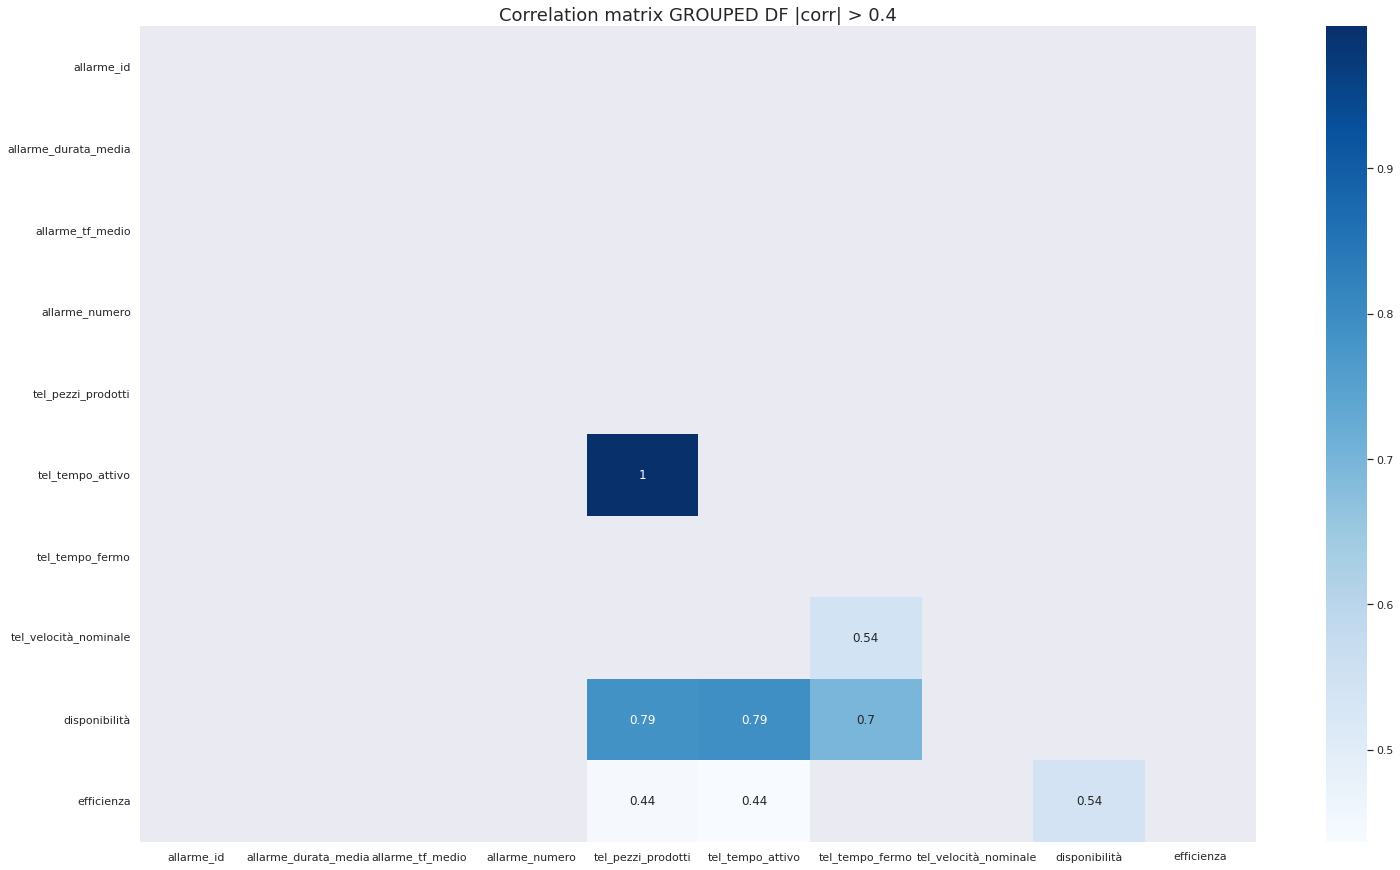

In [145]:
plt.figure(figsize = (25,15))
corr=abs(merged_df.corr())
lower_triangle  = np.tril(corr, k = -1)
mask = lower_triangle < abs(0.4) #Mask the correlation less than 0.6
sns.heatmap(lower_triangle,xticklabels = corr.index, yticklabels = corr.columns, annot = True,cmap= 'Blues', mask = mask)
plt.title('Correlation matrix GROUPED DF |corr| > 0.4',fontsize=18)
plt.show()

# Pre-Processing
Prepare a dataset to be used for the training. The dataset should include the features and the targets (KPI to be predicted). 

Inizialmente andiamo a splittare il dataset, poi a normalizzarlo.

Il tipo di split e' dipendente dalla quantita' di dati e dall'algoritmo che vogliamo utilizzare, come prima prova andremo a splittare il dataset in 2 split:
- train (70%)
- test (30%)

Alternativamente, in base al tipo di algoritmo se abbiamo bisogno di fare validazione di hyperparametri possiamo suddividerlo in 3 split:
- train (70%)
- validation (15%)
- test (15%)

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler #normalize

merged_df=pd.read_csv('/data/merged.csv')

merged_df=merged_df.round(decimals=2)
merged_df.head()

,timestamp,allarme_id,allarme_bloccante,allarme_durata_media,allarme_tf_medio,allarme_numero,tel_pezzi_prodotti,tel_tempo_attivo,tel_tempo_fermo,tel_velocità_nominale,disponibilità,efficienza
0,2020-04-09 04:00:00,70,True,1.5,2.0,2,703.69,1618,1980,0.46,0.45,0.94
1,2020-04-09 04:00:00,71,True,1.0,2.0,1,703.69,1618,1980,0.46,0.45,0.94
2,2020-04-09 04:00:00,72,True,1.0,2.0,1,703.69,1618,1980,0.46,0.45,0.94
3,2020-04-09 04:00:00,92,True,11.5,12.0,4,703.69,1618,1980,0.46,0.45,0.94
4,2020-04-09 04:00:00,102,True,2880.0,2907.0,1,703.69,1618,1980,0.46,0.45,0.94


In [116]:
# test without merge datasets
#merged_df=pd.read_csv('/data/telemetry.csv')
#merged_df['efficienza'].fillna(0,inplace=True)
#merged_df.isnull().sum()
#merged_df.head()

(1125,) (1125, 9)


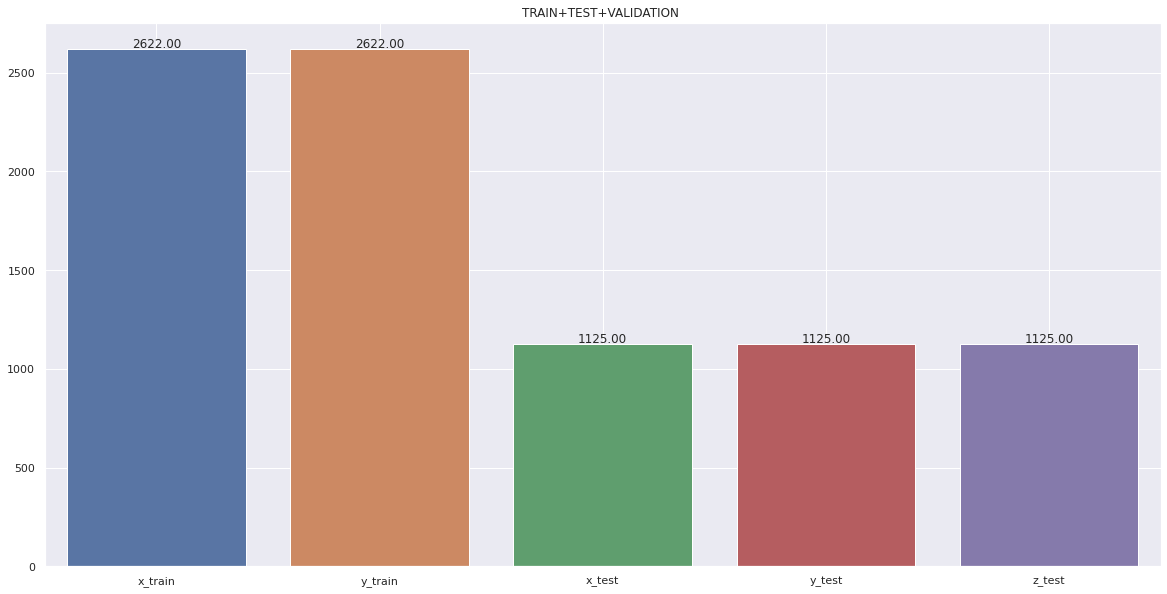

In [4]:
x = merged_df.drop(columns=['efficienza','disponibilità','timestamp'])
y = merged_df['efficienza'] # labels
z = merged_df['disponibilità']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.3, random_state=9)

_,_,z_train,z_test = train_test_split(x, z, test_size= 0.3, random_state=9)

#print(x_train.shape,x_temp.shape,y_train.shape,y_temp.shape)

#x_validation , x_test, y_validation, y_test = train_test_split(x_temp, y_temp, test_size=test_ratio/(test_ratio + validation_ratio),
#                                                               random_state=9)

print(y_test.shape,x_test.shape)
mydict={"x_train":[len(x_train)],"y_train":[len(y_train)],"x_test":[len(x_test)],"y_test":[len(y_test)],"z_test":[len(z_test)]}
sizes= pd.DataFrame.from_dict(mydict)

plot_bar_plot(sizes,title="TRAIN+TEST+VALIDATION ")

### Normalization

In [5]:
#normalize
def normalize_standard(x_train,x_test):
    scaler = StandardScaler()
    scaler.fit(pd.concat((x_train,x_test)))
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    return x_train,x_test


In [6]:
df=pd.DataFrame(x_train)
df.head()

,allarme_id,allarme_bloccante,allarme_durata_media,allarme_tf_medio,allarme_numero,tel_pezzi_prodotti,tel_tempo_attivo,tel_tempo_fermo,tel_velocità_nominale
2630,47,True,26.00,27.00,1,21.75,70,3529,0.46
3316,11,True,85.00,91.00,1,0.56,26,3570,0.46
2949,155,True,23.00,24.00,1,738.82,1733,1865,0.46
2750,114,True,53.25,54.75,4,861.49,1988,1612,0.46
917,104,True,6.00,52.00,1,70.82,211,3514,0.46


# Model Training and Evaluation
Train one or more models (feel free to use any library you are familiar with) and evaluate their performance.

## Linar Regression


In [7]:
# importing module
from sklearn.linear_model import LinearRegression

x_train_norm,x_test_norm=normalize_standard(x_train,x_test)

LR_eff = LinearRegression()
LR_eff.fit(x_train_norm,y_train)
LR_disp = LinearRegression()
LR_disp.fit(x_train_norm,z_train)


y_prediction =  LR_eff.predict(x_test_norm)
z_prediction =  LR_disp.predict(x_test_norm)

In [8]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# predicting the accuracy score
score_eff=r2_score(y_test,y_prediction)
score_disp=r2_score(z_test,z_prediction)
print('score efficienza',score_eff)
print('score disponibilita',score_disp)

score efficienza 0.3680262380384355
score disponibilita 0.8403200137832323


## Random Forest Regressor

In [9]:
from sklearn.ensemble import RandomForestRegressor
RF_eff = RandomForestRegressor(n_estimators=4, random_state=9)
RF_disp = RandomForestRegressor(n_estimators=4, random_state=9)

x_train_norm,x_test_norm=normalize_standard(x_train,x_test)

RF_eff.fit(x_train_norm,y_train)
RF_disp.fit(x_train_norm,z_train)

RandomForestRegressor(n_estimators=4, random_state=9)

In [10]:
y_prediction =  RF_eff.predict(x_test_norm)
z_prediction =  RF_disp.predict(x_test_norm)

score_eff=r2_score(y_test,y_prediction)
score_disp=r2_score(z_test,z_prediction)
print('score efficienza',score_eff)
print('score disponibilita',score_disp)

score efficienza 0.9878207568047546
score disponibilita 0.999460549526154


## KNN

In [11]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 

In [12]:
N_NEIGHBORS = 4
KNN_eff = neighbors.KNeighborsRegressor(n_neighbors = N_NEIGHBORS)
KNN_disp = neighbors.KNeighborsRegressor(n_neighbors = N_NEIGHBORS)

x_train_norm,x_test_norm=normalize_standard(x_train,x_test)

KNN_eff.fit(x_train_norm,y_train)
KNN_disp.fit(x_train_norm,z_train)

y_prediction = KNN_eff.predict(x_test_norm)
z_prediction = KNN_disp.predict(x_test_norm)

score_eff=r2_score(y_test,y_prediction)
score_disp=r2_score(z_test,z_prediction)
print('score efficienza',score_eff)
print('score disponibilita',score_disp)


score efficienza 0.6940986888497505
score disponibilita 0.9908446466969555


## Neural Network MLP

### Efficienza

In [13]:
from sklearn.neural_network import MLPRegressor

x_train_norm,x_test_norm=normalize_standard(x_train,x_test)

MLP_eff = MLPRegressor(random_state=1, max_iter=400,learning_rate='adaptive',verbose=True,solver='lbfgs').fit(x_train_norm, y_train)
y_prediction = MLP_eff.predict(x_test_norm)
score_eff=r2_score(y_test,y_prediction)
print('score efficienza',score_eff)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1101     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.89148D-01    |proj g|=  8.21899D-01

At iterate    1    f=  7.12497D-02    |proj g|=  9.14544D-02

At iterate    2    f=  2.82100D-02    |proj g|=  3.56222D-02

At iterate    3    f=  2.00004D-02    |proj g|=  2.11226D-02

At iterate    4    f=  1.61893D-02    |proj g|=  9.55998D-03

At iterate    5    f=  1.29617D-02    |proj g|=  1.14308D-02

At iterate    6    f=  9.36722D-03    |proj g|=  8.06411D-03

At iterate    7    f=  8.42209D-03    |proj g|=  8.18569D-03

At iterate    8    f=  7.70343D-03    |proj g|=  3.24914D-03

At iterate    9    f=  7.22405D-03    |proj g|=  3.15728D-03

At iterate   10    f=  6.88636D-03    |proj g|=  3.41624D-03

At iterate   11    f=  6.59840D-03    |proj g|=  1.94735D-03

At iterate   12    f=  6.35053D-03    |proj g|=  3.59249D-03

At iterate   13    f=  6.2

 This problem is unconstrained.



At iterate   40    f=  3.34354D-03    |proj g|=  1.90320D-03

At iterate   41    f=  3.28616D-03    |proj g|=  1.19398D-03

At iterate   42    f=  3.23795D-03    |proj g|=  1.13182D-03

At iterate   43    f=  3.20526D-03    |proj g|=  1.58031D-03

At iterate   44    f=  3.18042D-03    |proj g|=  1.22849D-03

At iterate   45    f=  3.14028D-03    |proj g|=  1.80568D-03

At iterate   46    f=  3.06686D-03    |proj g|=  1.18445D-03

At iterate   47    f=  3.05067D-03    |proj g|=  2.17965D-03

At iterate   48    f=  3.02379D-03    |proj g|=  1.06611D-03

At iterate   49    f=  3.00196D-03    |proj g|=  9.42213D-04

At iterate   50    f=  2.97963D-03    |proj g|=  1.42487D-03

At iterate   51    f=  2.96597D-03    |proj g|=  3.32681D-03

At iterate   52    f=  2.94562D-03    |proj g|=  1.34430D-03

At iterate   53    f=  2.92980D-03    |proj g|=  1.05468D-03

At iterate   54    f=  2.90578D-03    |proj g|=  1.55519D-03

At iterate   55    f=  2.86944D-03    |proj g|=  2.24898D-03

At iter


At iterate  175    f=  1.13532D-03    |proj g|=  1.25280D-03

At iterate  176    f=  1.12926D-03    |proj g|=  1.74484D-03

At iterate  177    f=  1.12559D-03    |proj g|=  3.02501D-03

At iterate  178    f=  1.12063D-03    |proj g|=  1.46623D-03

At iterate  179    f=  1.11714D-03    |proj g|=  6.65428D-04

At iterate  180    f=  1.11268D-03    |proj g|=  9.99068D-04

At iterate  181    f=  1.10576D-03    |proj g|=  1.38774D-03

At iterate  182    f=  1.09621D-03    |proj g|=  1.94534D-03

At iterate  183    f=  1.08860D-03    |proj g|=  1.49895D-03

At iterate  184    f=  1.08644D-03    |proj g|=  2.02677D-03

At iterate  185    f=  1.08473D-03    |proj g|=  1.63104D-03

At iterate  186    f=  1.08136D-03    |proj g|=  1.41858D-03

At iterate  187    f=  1.07637D-03    |proj g|=  7.10659D-04

At iterate  188    f=  1.07025D-03    |proj g|=  6.35782D-04

At iterate  189    f=  1.06533D-03    |proj g|=  2.23411D-03

At iterate  190    f=  1.06064D-03    |proj g|=  1.46748D-03

At iter


At iterate  310    f=  6.64418D-04    |proj g|=  6.32185D-04

At iterate  311    f=  6.63156D-04    |proj g|=  5.22416D-04

At iterate  312    f=  6.61893D-04    |proj g|=  1.00470D-03

At iterate  313    f=  6.59976D-04    |proj g|=  6.72328D-04

At iterate  314    f=  6.57845D-04    |proj g|=  7.00070D-04

At iterate  315    f=  6.56614D-04    |proj g|=  3.23124D-03

At iterate  316    f=  6.54540D-04    |proj g|=  8.92897D-04

At iterate  317    f=  6.52815D-04    |proj g|=  1.21007D-03

At iterate  318    f=  6.51647D-04    |proj g|=  1.13500D-03

At iterate  319    f=  6.49655D-04    |proj g|=  8.53170D-04

At iterate  320    f=  6.47219D-04    |proj g|=  7.38336D-04

At iterate  321    f=  6.44851D-04    |proj g|=  1.02423D-03

At iterate  322    f=  6.42183D-04    |proj g|=  2.40816D-03

At iterate  323    f=  6.39424D-04    |proj g|=  7.19349D-04

At iterate  324    f=  6.38187D-04    |proj g|=  2.27450D-03

At iterate  325    f=  6.37493D-04    |proj g|=  1.07006D-03

At iter

/usr/local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### Disponibilita

In [14]:
from sklearn.neural_network import MLPRegressor

x_train_norm,x_test_norm=normalize_standard(x_train,x_test)

MLP_eff = MLPRegressor(random_state=1, learning_rate='adaptive',verbose=True).fit(x_train_norm, z_train)
z_prediction = MLP_eff.predict(x_test_norm)
score_disp=r2_score(z_test,z_prediction)
print('score disponibilita',score_disp)

Iteration 1, loss = 0.08969796
Iteration 2, loss = 0.02149906
Iteration 3, loss = 0.00955030
Iteration 4, loss = 0.00545111
Iteration 5, loss = 0.00405982
Iteration 6, loss = 0.00298356
Iteration 7, loss = 0.00188853
Iteration 8, loss = 0.00144652
Iteration 9, loss = 0.00110572
Iteration 10, loss = 0.00088979
Iteration 11, loss = 0.00071535
Iteration 12, loss = 0.00073024
Iteration 13, loss = 0.00059741
Iteration 14, loss = 0.00049401
Iteration 15, loss = 0.00042806
Iteration 16, loss = 0.00039165
Iteration 17, loss = 0.00036484
Iteration 18, loss = 0.00033964
Iteration 19, loss = 0.00033772
Iteration 20, loss = 0.00031141
Iteration 21, loss = 0.00030024
Iteration 22, loss = 0.00028196
Iteration 23, loss = 0.00026781
Iteration 24, loss = 0.00026542
Iteration 25, loss = 0.00025308
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
score disponibilita 0.9936023389796804
